# Кластеризация & метрики качества

In [ ]:
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

### Данные

в sklearn.datasets есть разные наборы данных, можно выбрать другие

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

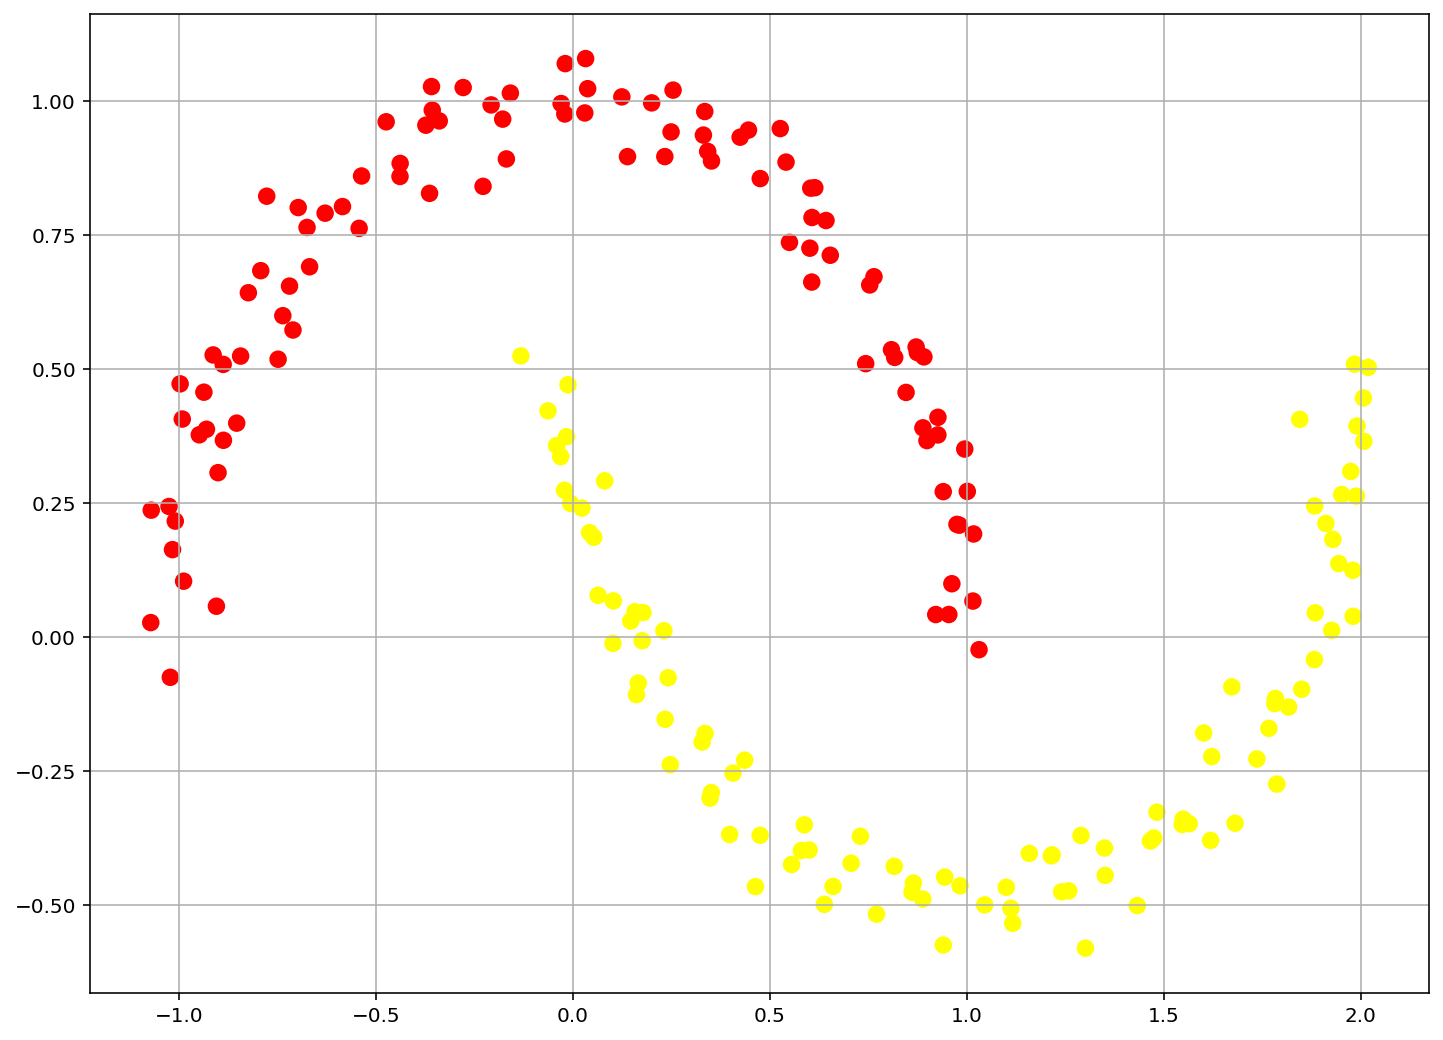

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=60)
plt.grid()

приведём данные по обеим осям к нормальному распределению

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_scaled = scaler.fit_transform(X)

форма осталась, но диапазоны выровнялись:

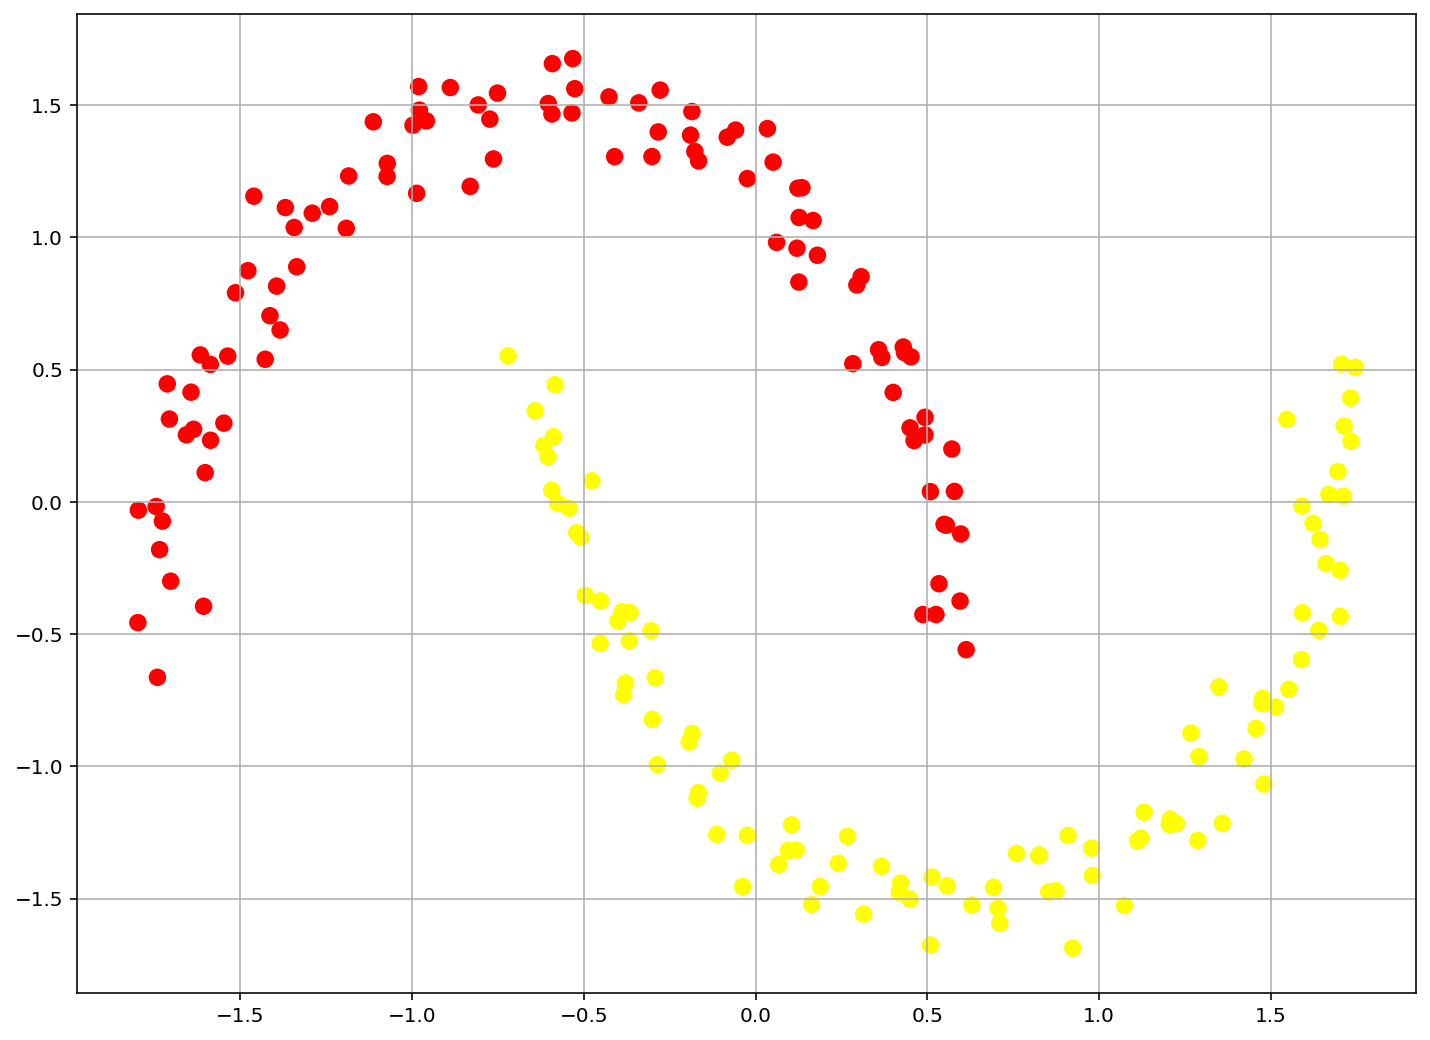

In [ ]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=60)
plt.grid()

### Кластеризация

теперь кластеризуем с помощью различных методов

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [ ]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
]

сделаем случайное предсказание

In [ ]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

и функцию-заготовку, которая считает 2 метрики качества и генерирует заголовки для графиков

In [ ]:
def get_descr(algo_name, y, y_pred, X):
    return "{}\nARI {:.2f}\nSilhouette {:.2f}".format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

проследите за ростом ARI и за падением Silhouette (хотя этот показатель по своему назначению тоже должен расти):

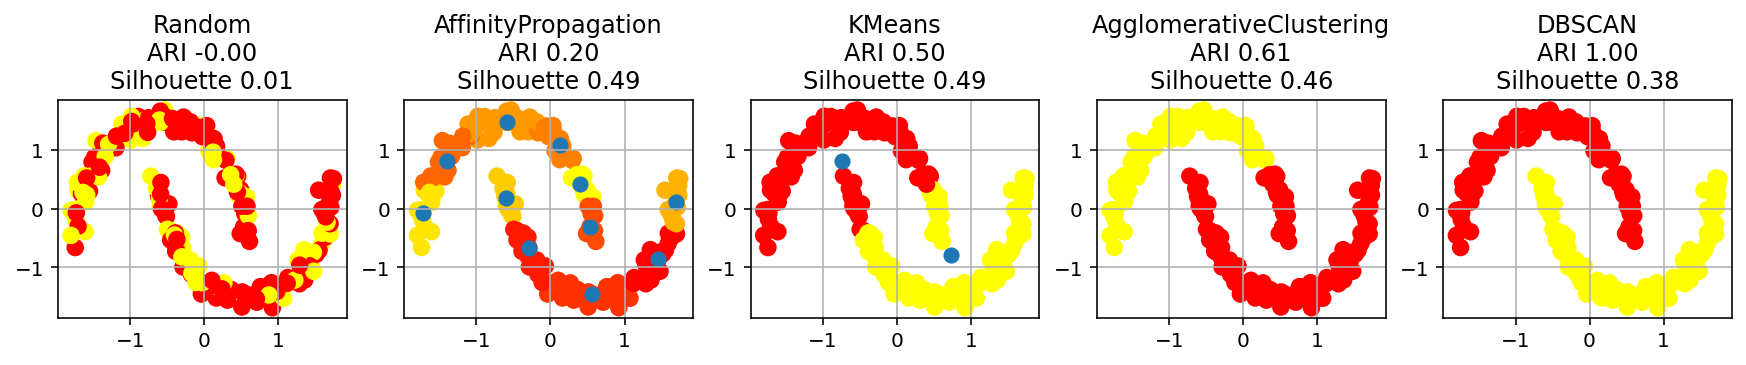

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60)
axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))
axes[0].grid()
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    ax.grid()
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)
        


# Подбор количества кластеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [ ]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

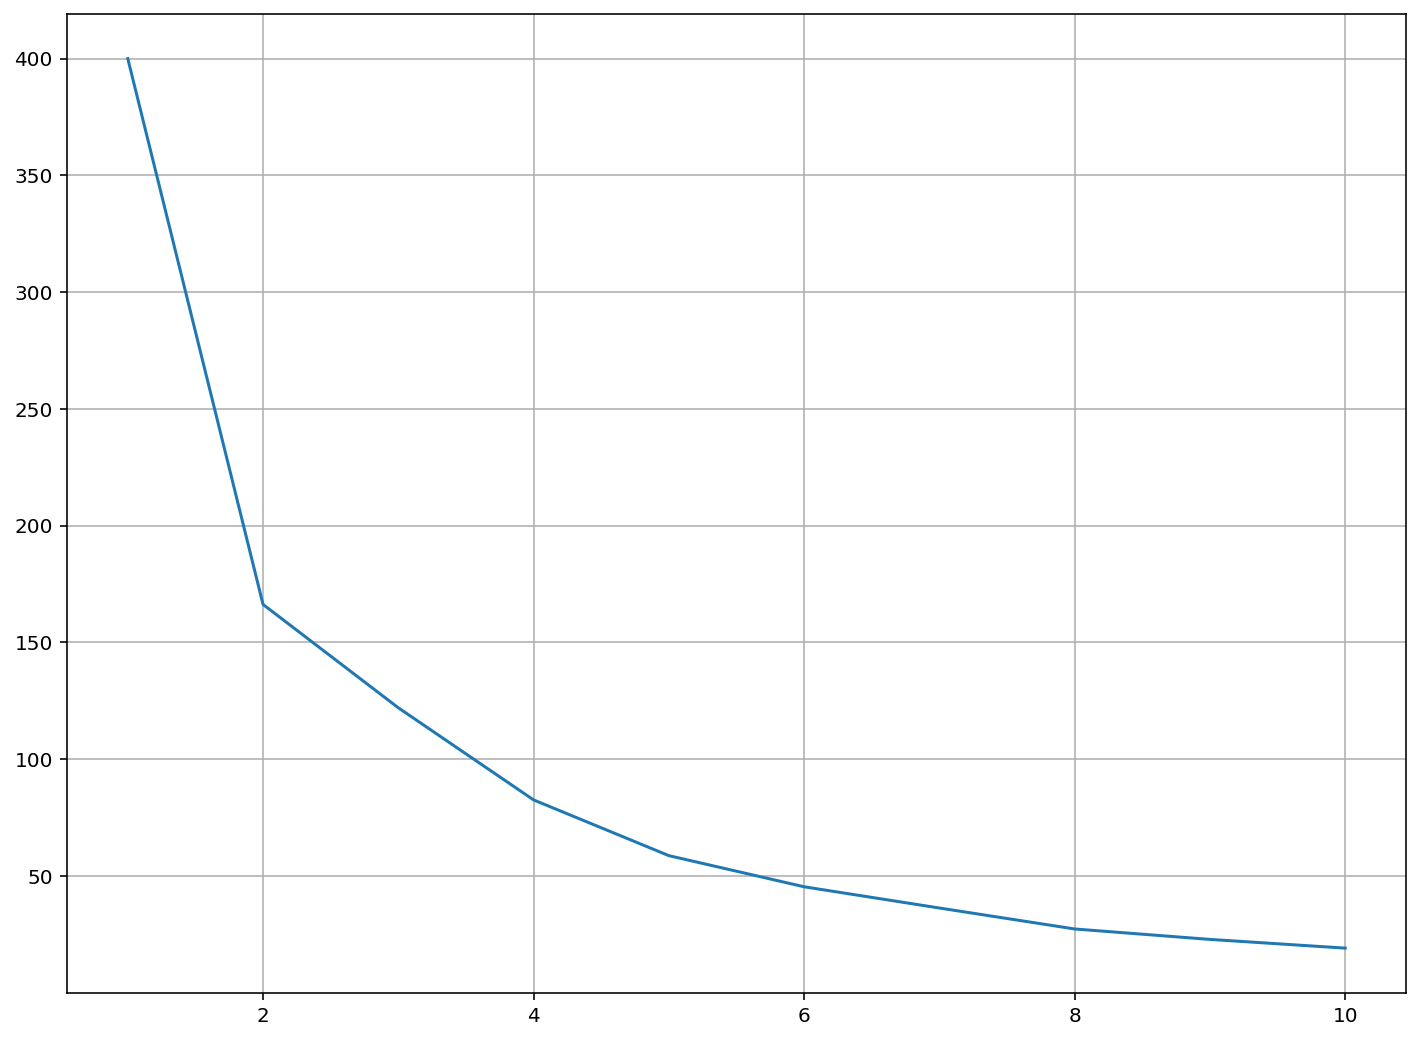

In [ ]:
plt.plot(ks, k_inertia)
plt.grid()

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

In [ ]:
diff = np.diff(k_inertia)

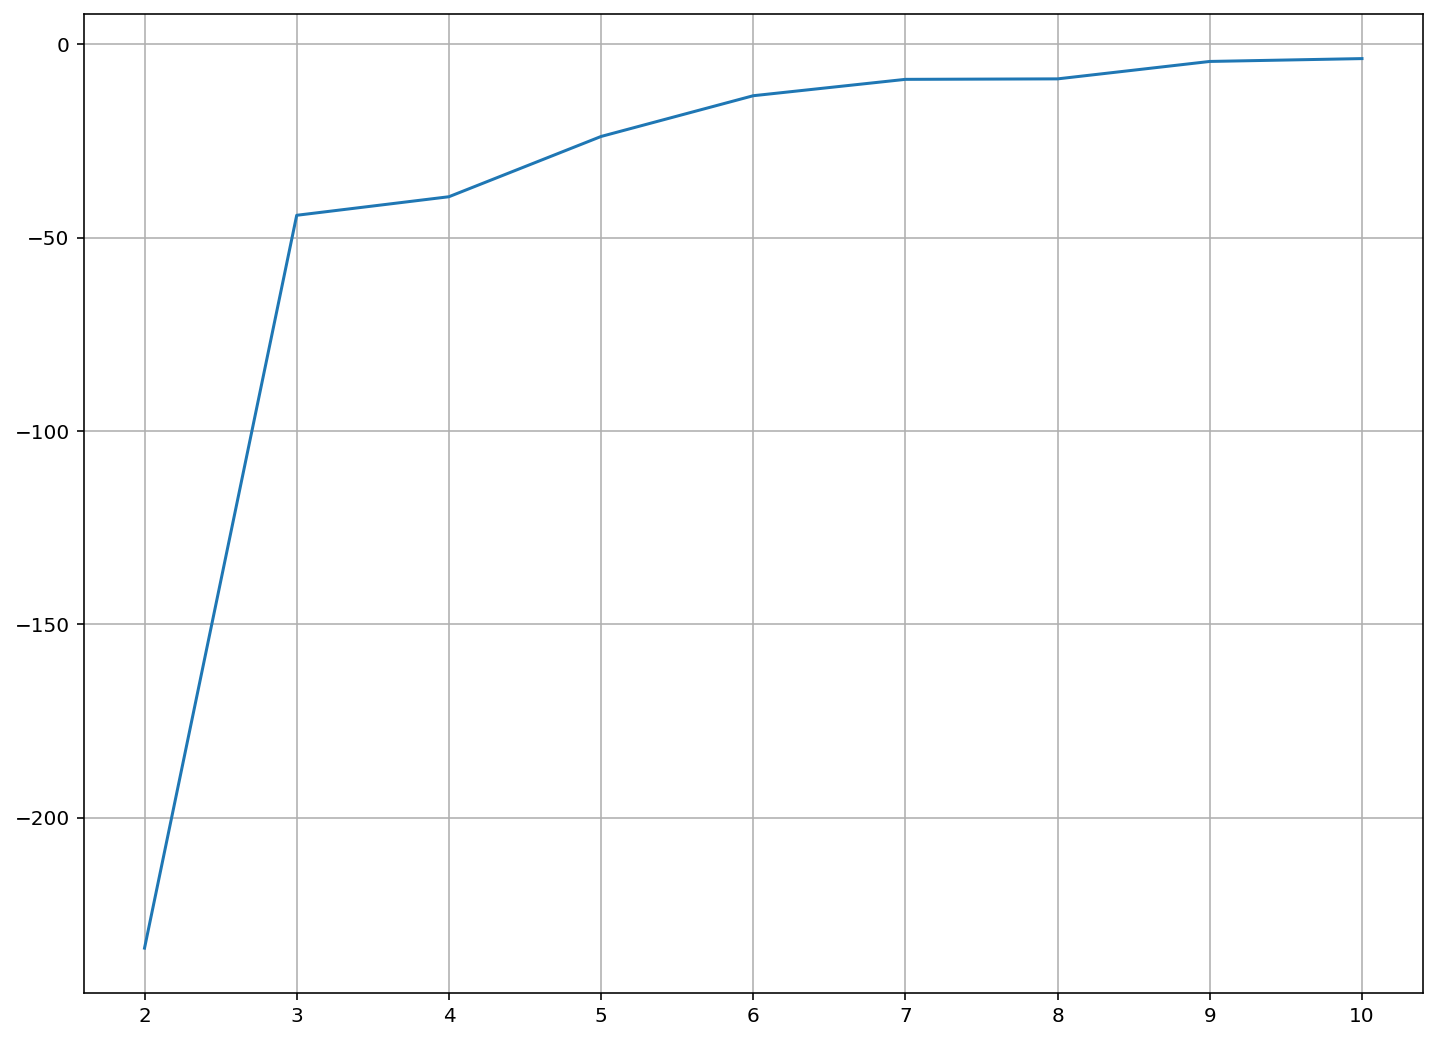

In [ ]:
plt.plot(ks[1:], diff)
plt.grid()

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [ ]:
diff_r = diff[1:] / diff[:-1]

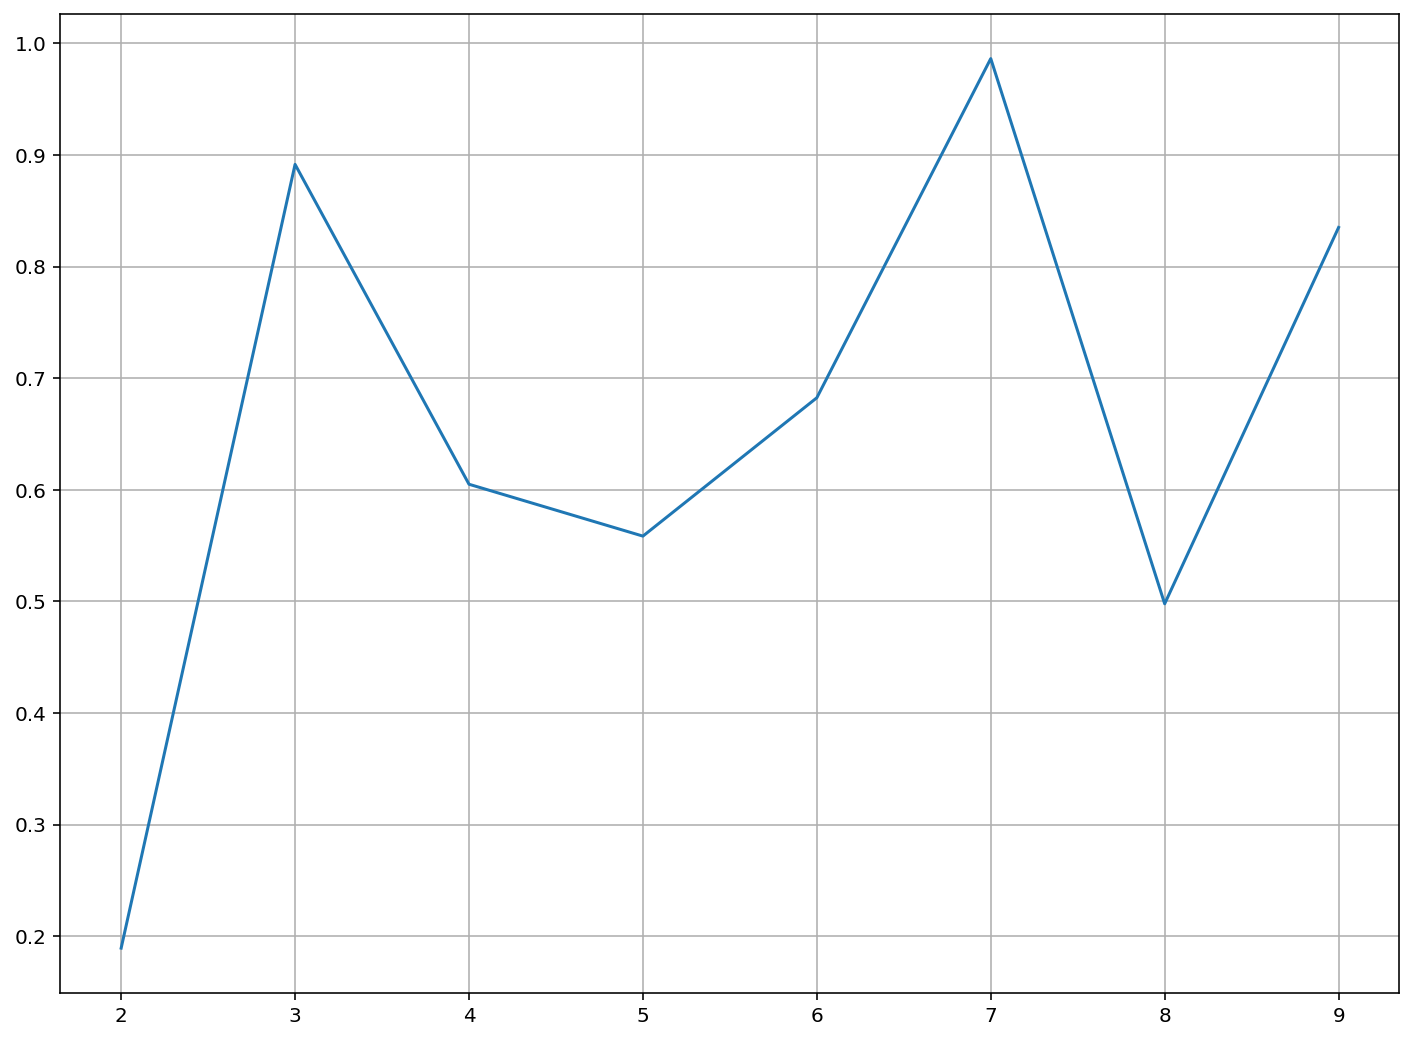

In [ ]:
plt.plot(ks[1:-1], diff_r)
plt.grid()

In [ ]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

Отмечу, что это эвристика и совсем не гарантирует наилучшее разбиение

In [ ]:
Дендограмма

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

x = np.zeros((150,2))
np.random.seed(seed=42)
x[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
x[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)
x[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
x[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

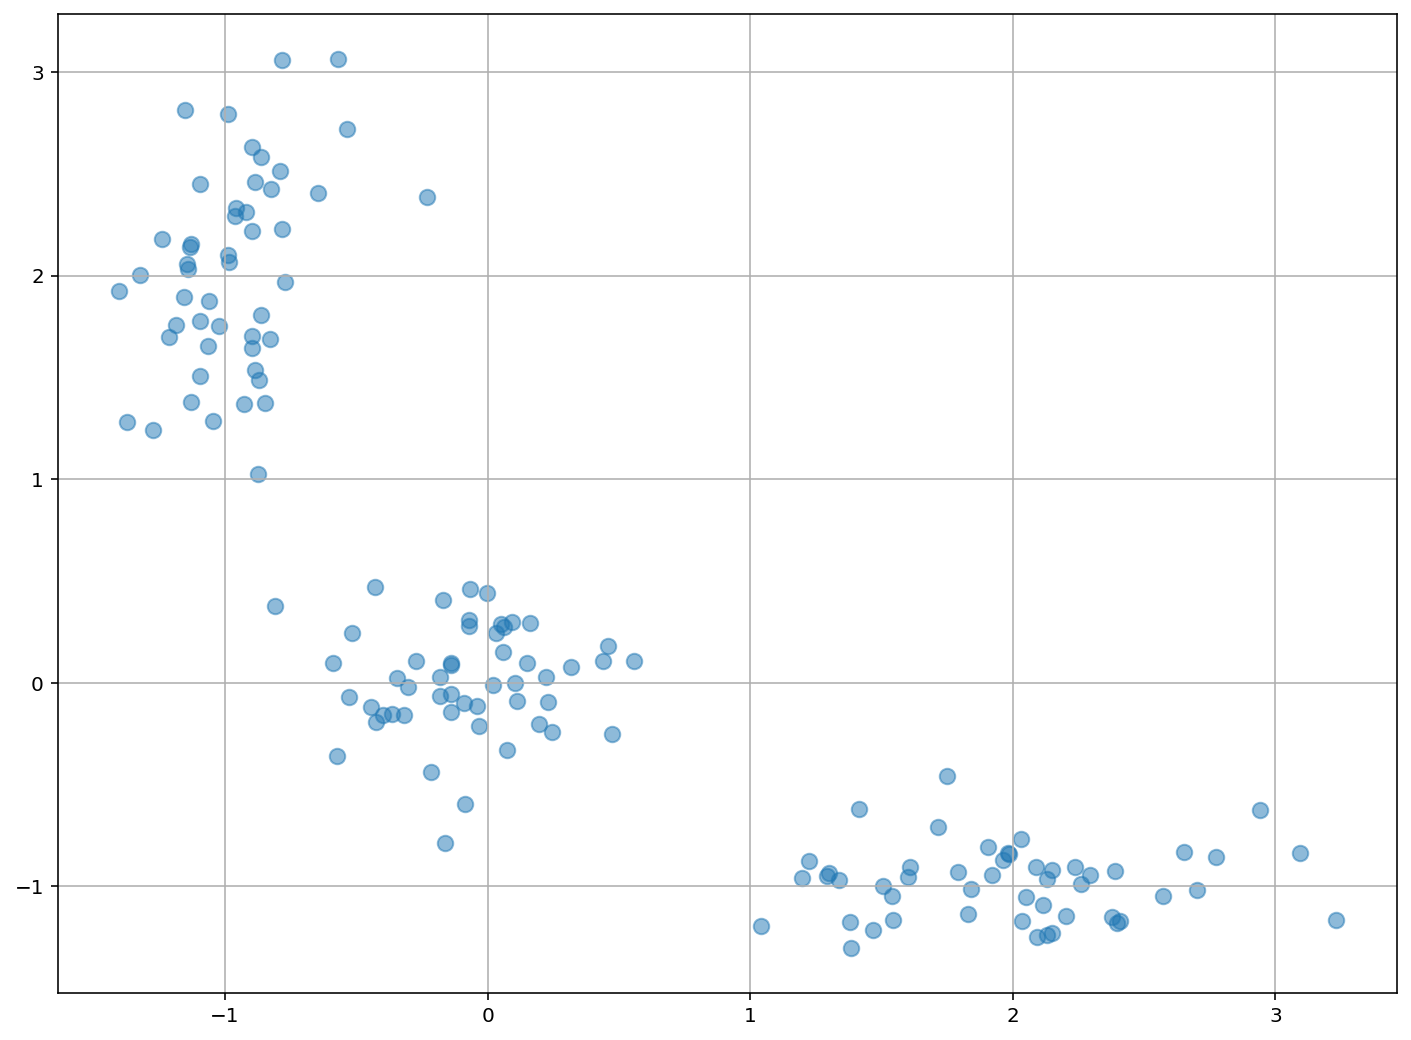

In [ ]:
plt.scatter(x[:,0],x[:,1], s=60, alpha=0.5)
plt.grid()

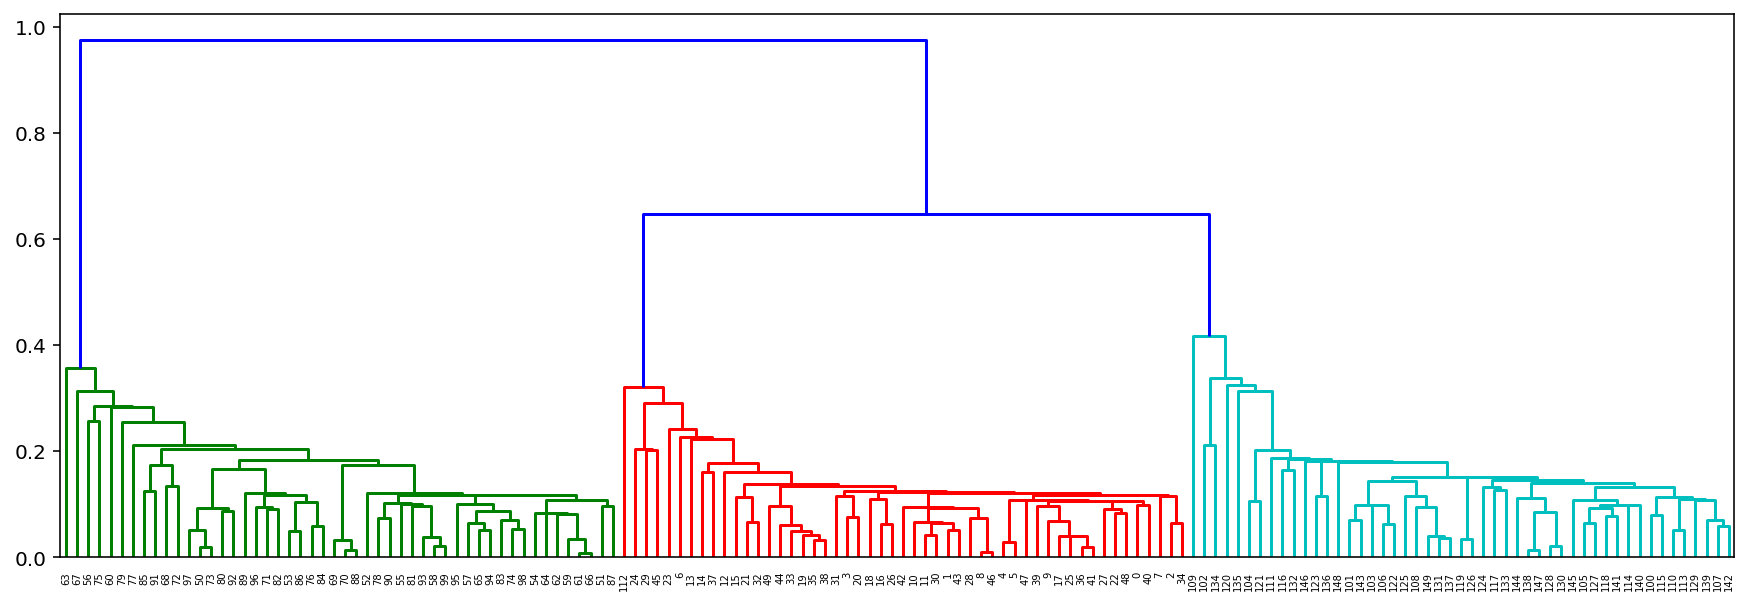

In [ ]:
distance_mat = pdist(x)

Z= hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)